In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

class HeatEquation2D:
    def __init__(self, L, W, T, Nx, Ny, Nt, k):
        self.L = L
        self.W = W
        self.T = T 
        self.Nx = Nx 
        self.Ny = Ny 
        self.Nt = Nt 
        self.k = k 

        self.dx = self.L / (self.Nx - 1)
        self.dy = self.W / (self.Ny - 1)
        self.dt = self.T / (self.Nt - 1)

        self.x = np.linspace(0, self.L, self.Nx)
        self.y = np.linspace(0, self.W, self.Ny)
        
        self.t = np.linspace(0, self.T, self.Nt)

        self.u = np.zeros((self.Nt, self.Ny, self.Nx))

        self.left_bc = lambda t, y: 0 
        self.right_bc = lambda t, y: 0
        self.bottom_bc = lambda t, x: 0 
        self.top_bc = lambda t, x: 0 
        self.f = lambda t, x, y: 0 

    def set_initial_condition(self, function):
        self.u[0] = function(self.x, self.y)

    def set_left_boundary_condition(self, bc):
        self.left_bc = bc

    def set_right_boundary_condition(self, bc):
        self.right_bc = bc

    def set_bottom_boundary_condition(self, bc):
        self.bottom_bc = bc

    def set_top_boundary_condition(self, bc):
        self.top_bc = bc

    def set_f(self, f):
        self.f = f

    def solve(self):
        Ax = self.k * self.dt / (self.dx ** 2)
        Bx = 1 + 2 * Ax
        Cx = -Ax

        Ay = self.k * self.dt / (self.dy ** 2)
        By = 1 + 2 * Ay
        Cy = -Ay

        for n in range(1, self.Nt):
            for j in range(1, self.Nx - 1):
                diag = By * np.ones(self.Ny)
                sub = Cy * np.ones(self.Ny - 1)
                sup = Cy * np.ones(self.Ny - 1)
                rhs = self.u[n - 1, :, j] 
                self.u[n, :, j] = np.linalg.solve(np.diag(diag, k=0) + np.diag(sub, k=-1) + np.diag(sup, k=1), rhs)

            self.u[n, 0, :] = self.left_bc(self.t[n], self.y)
            self.u[n, -1, :] = self.right_bc(self.t[n], self.y)
            self.u[n, :, 0] = self.bottom_bc(self.t[n], self.x)
            self.u[n, :, -1] = self.top_bc(self.t[n], self.x)

            for i in range(1, self.Ny - 1):
                diag = Bx * np.ones(self.Nx)
                sub = Cx * np.ones(self.Nx - 1)
                sup = Cx * np.ones(self.Nx - 1)
                rhs = self.u[n, i, :] 
                self.u[n, i, :] = np.linalg.solve(np.diag(diag, k=0) + np.diag(sub, k=-1) + np.diag(sup, k=1), rhs + self.f(self.x, self.y, self.t[n])[i, :] * self.dt)

            
            self.u[n, 0, :] = self.left_bc(self.t[n], self.y)
            self.u[n, -1, :] = self.right_bc(self.t[n], self.y)
            self.u[n, :, 0] = self.bottom_bc(self.t[n], self.x)
            self.u[n, :, -1] = self.top_bc(self.t[n], self.x)

        return self.u
    
    def animate_solution(self, save_as=None):
        fig, ax = plt.subplots(figsize=(10, 8))
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_title('Temperature distribution')
        im = ax.imshow(np.rot90(self.u[0]), extent=(0, self.L, 0, self.W), cmap='jet', vmin=-1, vmax=1)
        fig.colorbar(im, ax=ax)

        def update(frame):
            im.set_data(np.rot90(self.u[frame]))
            ax.set_title(f'Temperature distribution at t = {self.t[frame]:.2f}')
            return [im]

        ani = FuncAnimation(fig, update, frames=self.Nt, interval=50, blit=True)

        if save_as:
            ani.save(save_as, writer='ffmpeg')

        plt.show()
        
    def real_solution_test(self, f):
        ans = np.zeros((self.x.shape[0], self.y.shape[0]))
        for i in range(self.x.shape[0]):
            for j in range(self.y.shape[0]):
                ans[i, j] = f(self.x[i], self.y[j], self.t[-1])
        return np.max(np.abs(self.u[-1] - ans))
#         return np.exp(-(self.x[-1]**2 + self.y[-1]**2) / (1 + 4 * self.t[-1])) / (1 + 4 * self.t[-1])

        

Missing colon in file '/Users/vasilij/.matplotlib/matplotlibrc', line 1 ("animation.writer = 'ffmpeg'")


In [2]:

L = 1.0
W = 1.0
T = 0.1
Nx = 21
Ny = 21
Nt = 500
k = 1.0

heat_equation = HeatEquation2D(L, W, T, Nx, Ny, Nt, k)

def initial_condition(x, y):
    ans = np.zeros((x.shape[0], y.shape[0])) + 0.5
    for i in range(x.shape[0]):
        for j in range(y.shape[0]):
            ans[i, j] = np.sin(2 * np.pi * (x[i] + y[j]))
    return ans

def f(x, y, t):
    ans = np.zeros((x.shape[0], y.shape[0]))
    for i in range(x.shape[0]):
        for j in range(y.shape[0]):
            ans[i, j] = 1000 * np.sin(100*t) * np.heaviside(x[i] - 0.4, 0) * np.heaviside(0.6 - x[i], 0) * np.heaviside(y[j] - 0.4, 0) * np.heaviside(0.6 - y[j], 0)
    return ans

def left_boundary_condition(t, y):
    ans = np.zeros_like(y)
    # ans[np.logical_and(y > 0.4 , y < 0.6)] = 10 * t
    return ans

def right_boundary_condition(t, y):
    ans = np.zeros_like(y)
    # ans[np.logical_and(y > 0.4 , y < 0.6)] = 10 * t
    return ans

def bottom_boundary_condition(t, x):
    ans = np.zeros_like(x)
    # ans[np.logical_and(x > 0.4 , x < 0.6)] = 10 * t
    return ans

def top_boundary_condition(t, x):
    ans = np.zeros_like(x)
    # ans[np.logical_and(x > 0.4 , x < 0.6)] = 10 * t
    return ans






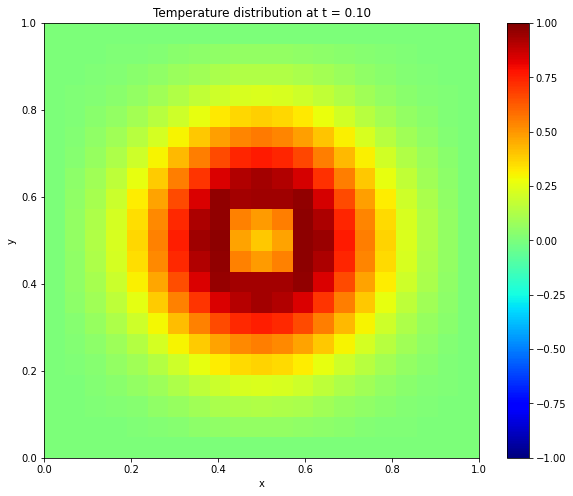

In [3]:
heat_equation = HeatEquation2D(L, W, T, Nx, Ny, Nt, k)
heat_equation.set_initial_condition(initial_condition)
heat_equation.set_left_boundary_condition(left_boundary_condition)
heat_equation.set_right_boundary_condition(right_boundary_condition)
heat_equation.set_bottom_boundary_condition(bottom_boundary_condition)
heat_equation.set_top_boundary_condition(top_boundary_condition)
heat_equation.set_f(f)
heat_equation.solve()
heat_equation.animate_solution("anim.mp4")

In [4]:
# from tqdm import tqdm 
# plot_data = []
# def real_sol(x, y, t):
#     return np.exp(-(x**2 + y**2) / (1 + 4 * t)) / (1 + 4 * t)

# for i in tqdm(r := np.arange(10, 30)):
#     heat_equation = HeatEquation2D(L, W, T, Nx, Ny, int(Nt * i / 10), k)
#     heat_equation.set_initial_condition(initial_condition)
#     heat_equation.set_left_boundary_condition(left_boundary_condition)
#     heat_equation.set_right_boundary_condition(right_boundary_condition)
#     heat_equation.set_bottom_boundary_condition(bottom_boundary_condition)
#     heat_equation.set_top_boundary_condition(top_boundary_condition)
#     heat_equation.set_f(f)
#     solution = heat_equation.solve()
#     plot_data.append(heat_equation.real_solution_test(real_sol))
# plt.plot(T / (Nt * r / 10), plot_data)

In [5]:
# plot_data = []
# for i in tqdm(r):
#     heat_equation = HeatEquation2D(L, W, T, int(Nx * i / 10), int(Ny * i / 10), Nt, k)
#     heat_equation.set_initial_condition(initial_condition)
#     heat_equation.set_left_boundary_condition(left_boundary_condition)
#     heat_equation.set_right_boundary_condition(right_boundary_condition)
#     heat_equation.set_bottom_boundary_condition(bottom_boundary_condition)
#     heat_equation.set_top_boundary_condition(top_boundary_condition)
#     heat_equation.set_f(f)
#     solution = heat_equation.solve()
#     plot_data.append(heat_equation.real_solution_test(real_sol))
# plt.plot(L / (Nx * r / 10), plot_data)

In [6]:
# plot_data = []
# for i in tqdm(r):
#     heat_equation = HeatEquation2D(L, W, T, int(Nx * i**0.5 / 10), int(Ny * i**0.5 / 10), int(Nt * i / 10), k)
#     heat_equation.set_initial_condition(initial_condition)
#     heat_equation.set_left_boundary_condition(left_boundary_condition)
#     heat_equation.set_right_boundary_condition(right_boundary_condition)
#     heat_equation.set_bottom_boundary_condition(bottom_boundary_condition)
#     heat_equation.set_top_boundary_condition(top_boundary_condition)
#     heat_equation.set_f(f)
#     solution = heat_equation.solve()
#     plot_data.append(heat_equation.real_solution_test(real_sol))
# plt.plot(L / (Nx * r / 10), plot_data)